In [8]:
root = "C:/Users/v-wangwilli/projects/nepas"
setwd(root)
.libPaths(file.path(root, "renv/library/windows/R-4.4/x86_64-w64-mingw32"))

library(jsonlite)
library(tidyverse)

In [27]:
process_year = function(year, root = "data/") {
  # Read all pages for a given year and process them into a single tibble
  year_path = file.path(root, as.character(year))
  pages = list.files(year_path) |>
    map(\(page_set) fromJSON(file.path(year_path, page_set)) |> as_tibble() |> mutate(page_numbers = page_set)) |> 
    bind_rows() |> 
    mutate(
      year = year,
      # Clean numeric columns
      across(
        total_units:public_valuation,
        \(col) col |>
          str_replace_all(" ", "") |>
          str_replace_all("-|\\*", "0") |> # "*" for Phoenix in 1977
          na_if("(X)") |>
          na_if("(S)") |> 
          as.integer()
      ),
      outside_indicator = as.numeric(str_detect(smsa_name, "OUTSIDE")),
      inside_indicator = as.numeric(str_detect(smsa_name, "INSIDE"))
    )
  if (str_detect(year_path, "1970")) {
    pages = pages |> 
      mutate(
        smsa_group = cumsum(inside_indicator) |> lead(default = sum(inside_indicator))
      )
  } else {
    pages = pages |> 
      mutate(
        smsa_group = cumsum(outside_indicator) |> lag(default = 0)
      )
  }
  pages |> 
    mutate(
      .by = smsa_group,
      smsa_indicator = as.numeric(row_number() == 1),
      city_indicator = as.numeric(
        smsa_indicator == 0 & outside_indicator == 0 & inside_indicator == 0
      )
    ) |> 
    filter(.by = smsa_group, !any(str_detect(smsa_name, "TOTAL"))) |>
    relocate(line_number, page_numbers, year, smsa_group)
}


In [28]:
years = 1967:1979

bps_raw = map(
  years,
  \(year) process_year(year, root = "data/raw_ocr/")
) |> bind_rows()

bps = bps_raw |> 
  mutate(
    total_units_diff = total_units - rowSums(pick(private_total, public_units)),
    private_total_diff = private_total - rowSums(pick(private_1_unit:private_5plus_units)),
    total_valuation_diff = total_valuation - rowSums(pick(private_valuation, public_valuation)),
    private_valuation_diff = private_valuation - rowSums(pick(private_1_unit_val:private_5plus_units_val))
  )

Out of all the validation checks (4 per row), how many pass?

In [29]:
validations = bps |>
  pivot_longer(contains("diff"), names_to = "diff_type", values_to = "diff_value")

validations |>
  count(abs(diff_value)) |>
  mutate(prop = round(n / sum(n), 4))

abs(diff_value),n,prop
<dbl>,<int>,<dbl>
0,42038,0.9139
1,3320,0.0722
2,51,0.0011
3,8,0.0002
4,7,0.0002
5,2,0.0000
6,1,0.0000
7,1,0.0000
8,1,0.0000


In [36]:
validations |>
  filter(diff_value >= 1000)

line_number,page_numbers,year,smsa_group,smsa_name,total_units,private_total,private_1_unit,private_2_units,private_3_4_units,⋯,private_2_units_val,private_3_4_units_val,private_5plus_units_val,public_valuation,outside_indicator,inside_indicator,smsa_indicator,city_indicator,diff_type,diff_value
<chr>,<chr>,<int>,<dbl>,<chr>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
39,pages_01_02.json,1974,10,ANAHEIM.,1325,1325,872,52,50,⋯,1098,0,6224,0,0,0,0,1,private_valuation_diff,1578
55,pages_25_26.json,1974,231,CHICOPEE,213,213,61,6,4,⋯,80,166,1494,0,0,0,0,1,private_valuation_diff,1000
10,pages_15_16.json,1978,127,LANCASTER.,173,173,18,4,0,⋯,84,1165,0,0,0,0,0,1,private_valuation_diff,2309
53,pages_23_24.json,1978,209,"RICHLAND-KENNEWICK-PASCO, WASH.",3259,3259,2150,162,203,⋯,4034,4293,10285,0,0,0,1,0,private_valuation_diff,10000
26,pages_09_10.json,1979,81,INSIDE CENTRAL CITIES,879,879,222,144,16,⋯,5317,360,13707,0,0,1,0,0,private_valuation_diff,1434
28,pages_09_10.json,1979,81,MOORHEAD,317,317,107,70,4,⋯,2774,148,2436,0,0,0,0,1,private_valuation_diff,1434


In [35]:
# Check NAs
validations |>
  filter(is.na(diff_value) & if_any(total_units:public_valuation, \(x) !is.na(x))) |>
  distinct(pick(line_number:year, total_units:public_valuation))


line_number,page_numbers,year,total_units,private_total,private_1_unit,private_2_units,private_3_4_units,private_5plus_units,public_units,private_structures,total_valuation,private_valuation,private_1_unit_val,private_2_units_val,private_3_4_units_val,private_5plus_units_val,public_valuation
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
2,pages_13_14.json,1967,166,166,146,0,0,20,NA,NA,849,849,793,NA,NA,57,NA
44,pages_17_18.json,1969,77,77,69,8,0,0,NA,NA,1658,1658,1548,110,0,0,NA
45,pages_17_18.json,1969,NA,NA,NA,NA,NA,NA,0,12,NA,NA,NA,NA,NA,NA,0
33,pages_21_22.json,1975,NA,NA,NA,NA,NA,NA,0,NA,NA,NA,NA,NA,NA,NA,0
24,pages_23_24.json,1975,NA,NA,NA,NA,NA,NA,0,NA,NA,NA,NA,NA,NA,NA,0
20,pages_25_26.json,1976,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0,NA
44,pages_01_02.json,1977,NA,NA,NA,NA,NA,NA,0,NA,NA,NA,NA,NA,NA,NA,0
35,pages_05_06.json,1977,NA,NA,NA,NA,NA,NA,0,NA,NA,NA,NA,NA,NA,NA,0
20,pages_13_14.json,1977,NA,NA,NA,NA,NA,NA,0,NA,NA,NA,NA,NA,NA,NA,0


In [ ]:



bps |> 
  pivot_longer(contains("diff"), names_to = "diff_type", values_to = "diff_value") |> 
  filter(diff_value != 0)

#' 




bps |>
  filter(.by = smsa_group, !any(str_detect(smsa_name, "TOTAL"))) |> 
  nrow()

bps |> 
  filter(smsa_indicator == 1) |> 
  ggplot() +
  geom_histogram(aes(x = total_units))



list.files("raw_ocr/1977", full.names = TRUE) |>
  map(\(x) fromJSON(x) |> as_tibble()) |> 
  bind_rows() |> 
  mutate(
    across(
      total_units:public_valuation,
      \(col) col |>
        str_replace_all(" ", "") |>
        str_replace_all("-", "0") |>
        na_if("(X)") |>
        na_if("(S)")
    )
  ) |> 
  pivot_longer(
    total_units:public_valuation
  ) |> 
  filter(as.numeric(value) |> is.na() & !is.na(value))






# Name matching

In [83]:
dplyr::filter

function (.data, ..., .by = NULL, .preserve = FALSE) 
{
    check_by_typo(...)
    by <- enquo(.by)
    if (!quo_is_null(by) && !is_false(.preserve)) {
        abort("Can't supply both `.by` and `.preserve`.")
    }
    UseMethod("filter")
}
<bytecode: 0x0000023282b32900>
<environment: namespace:dplyr>

In [98]:
bps = bps |>
  mutate(
    smsa_name_clean = smsa_name |>
      str_remove_all("[0-9]|\\.|\\*|#") |>
      str_replace_all(" *- *", "-") |>
      str_squish() # Remove whitespace from ends and turn multiple spaces into one
  )

bps_smsa = bps |>
  filter(smsa_indicator == 1)

smsa_names = bps_smsa |>
  summarize(.by = smsa_name_clean, smsa_name = str_c(unique(smsa_name), collapse = " | "), line_number = first(line_number), year = first(year), page_numbers = first(page_numbers)) |>
  arrange(smsa_name_clean)

write_csv(smsa_names, "data/mappings/smsa_names.csv")

In [102]:
smsa_name_mapping = read_csv("data/mappings/smsa_name_mapping.csv")

Rows: 377 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): smsa_name_clean, smsa_name_corrected

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [105]:
bps_smsa |>
  count(smsa_name, year) |>
  filter(n > 1)

smsa_name,year,n
<chr>,<int>,<int>


In [108]:
1

[1] 1

In [110]:
bps_corrected = bps_smsa |>
  left_join(smsa_name_mapping, join_by(smsa_name_clean)) |>
  summarize(
    .by = c(smsa_name_corrected, year),
    across(total_units:public_valuation, \(col) sum(col, na.rm = TRUE))
  )

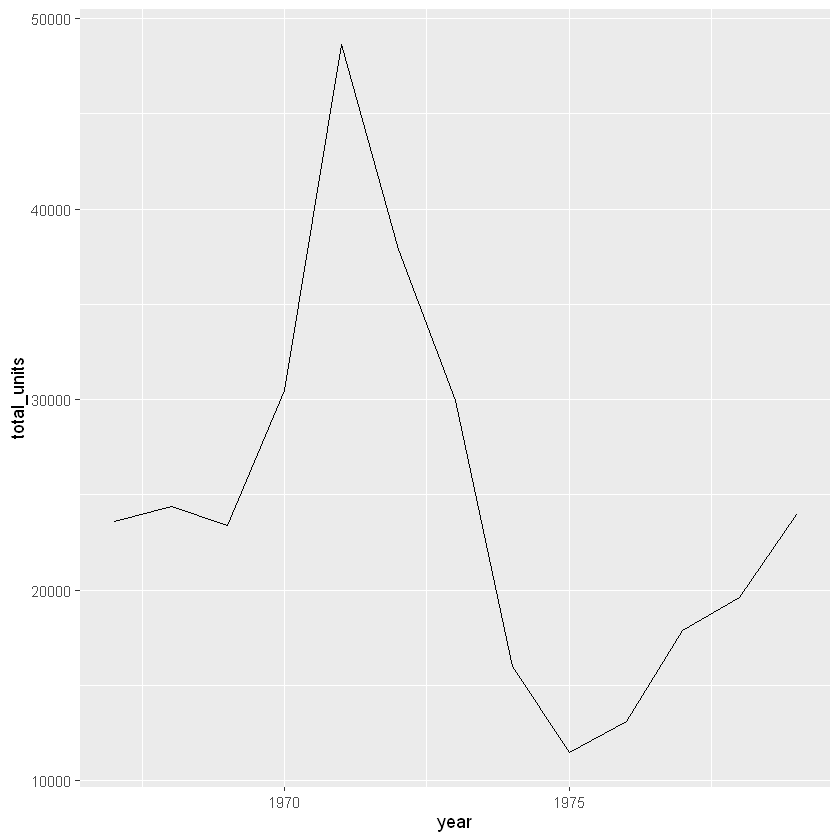

In [115]:
ggplot(bps_corrected |> filter(smsa_name_corrected |> str_detect("ATLANTA"))) +
  geom_line(aes(x = year, y = total_units))

## Manually cleaning 
- corrected obvious typographical errors or inconsistencies
- took largest geographical area when possible --> combined multiple rows in earlier files

To-do:
- fuzzy matching to make sure didn't miss inclusions
- state coding

In [44]:
bps |>
  filter(smsa_indicator == 1 & !str_detect(smsa_name, ","))

line_number,page_numbers,year,smsa_group,smsa_name,total_units,private_total,private_1_unit,private_2_units,private_3_4_units,⋯,private_5plus_units_val,public_valuation,outside_indicator,inside_indicator,smsa_indicator,city_indicator,total_units_diff,private_total_diff,total_valuation_diff,private_valuation_diff
<chr>,<chr>,<int>,<dbl>,<chr>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
48,pages_05_06.json,1968,49,DAVENPORT-ROCK ISLAND-MOLINE; IOWA-ILL.,2976,2976,1867,164,51,⋯,8717,0,0,0,1,0,0,0,0,0
56,pages_15_16.json,1968,133,NASHVILLE AND DAVIDSON COUNTY TENN.3,7586,7191,2736,256,90,⋯,26870,4333,0,0,1,0,0,0,0,1
22,pages_23_24.json,1971,186,PROVIDENCE-WARWICK-PAWTUCKET-R.I.-MASS.,7360,7205,2685,236,130,⋯,30164,2293,0,0,1,0,0,0,0,0
52,pages_25_26.json,1971,210,SAN FRANCISCO-OAKLAND CALIF.,38766,38766,16553,836,2042,⋯,267598,0,0,0,1,0,0,0,0,0
25,pages_01_02.json,1972,7,ALLENTOWN-BETH.-EASTON PA.-N.J.,5823,5823,2843,188,74,⋯,29897,0,0,0,1,0,0,0,0,-1
62,pages_07_08.json,1972,73,FARGO-MOOREHEAD ND-MN.,1069,1069,403,64,42,⋯,6529,0,0,0,1,0,0,0,0,0
27,pages_11_12.json,1972,99,HUNTINGTON-ASHLAND WV-KY-OH.,666,666,362,8,15,⋯,3059,0,0,0,1,0,0,0,0,0
42,pages_13_14.json,1972,121,LAWRENCE-HAVERHILL MA-NH,2893,2893,895,114,4,⋯,17458,0,0,0,1,0,0,0,0,0
66,pages_17_18.json,1972,163,NASSAU-SUFFOLK 2.,16692,16692,12756,276,12,⋯,40330,0,0,0,1,0,0,0,0,1


In [ ]:
nrow()